# PAMAP2

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv1D, MaxPool1D, BatchNormalization, Dense,
                                     Input, ReLU, Dropout, LayerNormalization,
                                     MultiHeadAttention, GlobalAveragePooling1D, GRU)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/AI_data/PAMAP2/PAMAP2_integrated_data.csv')

In [4]:
df.head()

,timestamp,activityID,heart_rate,hand_temp,hand_acc_16g_x,hand_acc_16g_y,hand_acc_16g_z,hand_acc_6g_x,hand_acc_6g_y,hand_acc_6g_z,...,ankle_gyro_y,ankle_gyro_z,ankle_mag_x,ankle_mag_y,ankle_mag_z,ankle_orient_1,ankle_orient_2,ankle_orient_3,ankle_orient_4,subject
0,8.38,0.0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0,Protocol_subject101
1,8.39,0.0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0,Protocol_subject101
2,8.40,0.0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0,Protocol_subject101
3,8.41,0.0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0,Protocol_subject101
4,8.42,0.0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0,Protocol_subject101


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3850505 entries, 0 to 3850504
Data columns (total 55 columns):
 #   Column           Dtype  
---  ------           -----  
 0   timestamp        float64
 1   activityID       float64
 2   heart_rate       float64
 3   hand_temp        float64
 4   hand_acc_16g_x   float64
 5   hand_acc_16g_y   float64
 6   hand_acc_16g_z   float64
 7   hand_acc_6g_x    float64
 8   hand_acc_6g_y    float64
 9   hand_acc_6g_z    float64
 10  hand_gyro_x      float64
 11  hand_gyro_y      float64
 12  hand_gyro_z      float64
 13  hand_mag_x       float64
 14  hand_mag_y       float64
 15  hand_mag_z       float64
 16  hand_orient_1    float64
 17  hand_orient_2    float64
 18  hand_orient_3    float64
 19  hand_orient_4    float64
 20  chest_temp       float64
 21  chest_acc_16g_x  float64
 22  chest_acc_16g_y  float64
 23  chest_acc_16g_z  float64
 24  chest_acc_6g_x   float64
 25  chest_acc_6g_y   float64
 26  chest_acc_6g_z   float64
 27  chest_gyro_x

In [6]:
df = df.drop(columns=['timestamp', 'heart_rate', 'hand_temp', 'hand_acc_6g_x', 'hand_acc_6g_y', 'hand_acc_6g_z', 'hand_orient_1', 'hand_orient_2', 'hand_orient_3', 'hand_orient_4',
                 'chest_temp', 'chest_acc_6g_x', 'chest_acc_6g_y', 'chest_acc_6g_z', 'chest_orient_1', 'chest_orient_2', 'chest_orient_3', 'chest_orient_4', 'ankle_temp', 'ankle_acc_6g_x', 'ankle_acc_6g_y', 'ankle_acc_6g_z',
                 'ankle_orient_1', 'ankle_orient_2', 'ankle_orient_3', 'ankle_orient_4'])

In [7]:
df.isna().sum()

,0
activityID,0
hand_acc_16g_x,14338
hand_acc_16g_y,14338
hand_acc_16g_z,14338
hand_gyro_x,14338
hand_gyro_y,14338
hand_gyro_z,14338
hand_mag_x,14338
hand_mag_y,14338
hand_mag_z,14338


활동(activity)별 데이터프레임 구성 및 NaN 처리
- activityID 0을 제외하고 필요한 활동(집안일 등 생활잡음을 제외한 12개)만 사용
- 활동 별로 fill와 bill을 이용해서 결측값을 처리 -> 활동의 고유한 패턴이 왜곡되지 않도록

In [8]:
activity_mapping = {
        1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6,
        12: 7, 13: 8, 16: 9, 17: 10, 24: 11
    }
df = df[df["activityID"].isin(activity_mapping.keys())]

# 각 활동(activity)별로 DataFrame을 구성하고, bfill과 ffill을 적용하여 NaN 처리
df_list = []
for activity_id in df['activityID'].unique():
    activity_df = df[df['activityID'] == activity_id].copy()
    # ffill과 bfill을 순차적으로 적용하여 결측치 채우기
    activity_df = activity_df.fillna(method='ffill').fillna(method='bfill')
    # 또는 선형 보간 사용 (linear interpolation)
    # activity_df = activity_df.interpolate(method='linear')
    df_list.append(activity_df)

# 처리된 DataFrame들을 다시 하나로 합치기
df_processed = pd.concat(df_list, ignore_index=True)
df_processed.head()

/tmp/ipython-input-2476589672.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  activity_df = activity_df.fillna(method='ffill').fillna(method='bfill')


,activityID,hand_acc_16g_x,hand_acc_16g_y,hand_acc_16g_z,hand_gyro_x,hand_gyro_y,hand_gyro_z,hand_mag_x,hand_mag_y,hand_mag_z,...,ankle_acc_16g_x,ankle_acc_16g_y,ankle_acc_16g_z,ankle_gyro_x,ankle_gyro_y,ankle_gyro_z,ankle_mag_x,ankle_mag_y,ankle_mag_z,subject
0,1.0,2.21530,8.27915,5.58753,-0.004750,0.037579,-0.011145,8.93200,-67.9326,-19.9755,...,9.73855,-1.84761,0.095156,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696,Protocol_subject101
1,1.0,2.29196,7.67288,5.74467,-0.171710,0.025479,-0.009538,9.58300,-67.9584,-20.9091,...,9.69762,-1.88438,-0.020804,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656,Protocol_subject101
2,1.0,2.29090,7.14240,5.82342,-0.238241,0.011214,0.000831,9.05516,-67.4017,-19.5083,...,9.69633,-1.92203,-0.059173,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119,Protocol_subject101
3,1.0,2.21800,7.14365,5.89930,-0.192912,0.019053,0.013374,9.92698,-67.4387,-20.5602,...,9.66370,-1.84714,0.094385,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799,Protocol_subject101
4,1.0,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582,9.15626,-67.1825,-20.0857,...,9.77578,-1.88582,0.095775,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847,Protocol_subject101


time series 데이터에서 MinMaxScaler를 더 자주 쓰는 이유
- LSTM/GRU는 sigmoid, tanh 같은 함수로 계산되기 때문에 입력이 [0,1], [-1,1]로 정리되어 있는 MinMaxScaler가 선호됨
- StandardScaler는 값이 커지거나 작아질 때 포화 구간에 들어갈 수 있음 -> Gradient Vanishing
- MinMaxScaler는 범위를 0~1로 맞춰서 패턴을 그대로 비교할 수 있음

In [9]:
scaler = MinMaxScaler()
features_to_scale = df_processed.columns.drop(['subject', 'activityID'])
df_processed[features_to_scale] = scaler.fit_transform(df_processed[features_to_scale])

In [10]:
TIME_STEPS = 100 # 1 sec (100Hz sampling)
STEPS = 50 # 50% 오버랩

def create_dataset(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(x)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

X = df_processed.drop(columns=['activityID', 'subject'])
y = df_processed['activityID'].map(activity_mapping)

# 시퀀스 데이터 생성
X_seq, y_seq = create_dataset(X, y, TIME_STEPS, STEPS)

print(f"변환된 시퀀스 데이터 shape: {X_seq.shape}")
print(f"변환된 레이블 shape: {y_seq.shape}")

변환된 시퀀스 데이터 shape: (38856, 100, 27)
변환된 레이블 shape: (38856, 1)


Stratified(계층적으로)하게 train/val/test split
- stratify: 데이터를 분할할 때 각 서브셋에 클래스의 비율이 동일하게 반영되게끔 함
- e.g. 걷기 50%, 달리기 30%, 자전거 타기 20%라면 훈련/검증/테스트 데이터셋에도 유사한 비율로 반영됨

In [11]:
# train:val:test 비율 -> 80:10:10
test_size = 0.1
val_size = 0.1

# 전체 데이터에서 테스트 셋을 먼저 분리 (stratify=y_seq를 사용하여 클래스 비율 유지)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_seq, y_seq, test_size=test_size, random_state=42, stratify=y_seq
)

# 남은 데이터(훈련+검증)에서 검증 셋을 분리 (stratify=y_train_val를 사용하여 클래스 비율 유지)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=val_size / (1 - test_size), random_state=42, stratify=y_train_val
)

# 분할된 데이터셋의 최종 크기 확인
print("\n데이터 분할 완료:")
print(f"훈련 셋 크기: X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}")
print(f"검증 셋 크기: X_val.shape = {X_val.shape}, y_val.shape = {y_val.shape}")
print(f"테스트 셋 크기: X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}")


데이터 분할 완료:
훈련 셋 크기: X_train.shape = (31084, 100, 27), y_train.shape = (31084, 1)
검증 셋 크기: X_val.shape = (3886, 100, 27), y_val.shape = (3886, 1)
테스트 셋 크기: X_test.shape = (3886, 100, 27), y_test.shape = (3886, 1)


In [12]:
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(np.unique(y_train))

model = Sequential([
        Conv1D(64, 5, activation='relu', input_shape=input_shape),
        BatchNormalization(),

        Conv1D(128, 3, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        MaxPool1D(2),

        Conv1D(256, 3, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        GRU(256, return_sequences=True, dropout=0.3),
        GRU(128, dropout=0.3),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 96, 64)         │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 94, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 94, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 94, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 47, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 45, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 45, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 45, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 45, 256)        │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 128)            │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 686,028 (2.62 MB)

 Trainable params: 685,004 (2.61 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [13]:
callbacks = [
            ModelCheckpoint(
                "PAMAP2_CNN_GRU_best.h5",
                save_best_only=True,
                monitor="val_sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_sparse_categorical_accuracy",
                patience=15,
                verbose=1,
                mode='max',
                restore_best_weights=True
            ),
            ReduceLROnPlateau(
                monitor='val_sparse_categorical_accuracy', # val_sparse_categorical_accuracy가 epoch 10 동안 개선되지 않으면
                factor=0.1, # 학습률을 0.1배로 줄임
                patience=10,
                min_lr=0.00001, # 학습률의 최솟값
                verbose=1)
        ]

In [14]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=64,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1892 - sparse_categorical_accuracy: 0.6423
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.31163, saving model to PAMAP2_CNN_GRU_best.h5


486/486 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 1.1883 - sparse_categorical_accuracy: 0.6425 - val_loss: 3.2560 - val_sparse_categorical_accuracy: 0.3116 - learning_rate: 0.0010
Epoch 2/100
485/486 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3711 - sparse_categorical_accuracy: 0.8940
Epoch 2: val_sparse_categorical_accuracy improved from 0.31163 to 0.46320, saving model to PAMAP2_CNN_GRU_best.h5


486/486 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.3710 - sparse_categorical_accuracy: 0.8940 - val_loss: 1.7985 - val_sparse_categorical_accuracy: 0.4632 - learning_rate: 0.0010
Epoch 3/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2593 - sparse_categorical_accuracy: 0.9257
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.46320
486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.2593 - sparse_categorical_accuracy: 0.9257 - val_loss: 3.1581 - val_sparse_categorical_accuracy: 0.4161 - learning_rate: 0.0010
Epoch 4/100
484/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2093 - sparse_categorical_accuracy: 0.9380
Epoch 4: val_sparse_categorical_accuracy did not improve from 0.46320
486/486 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.2093 - sparse_categorical_accuracy: 0.9380 - val_loss: 2.0350 - val_sparse_categorical_accuracy: 0.4519 - learning_rate: 0.0010
Epoch 5/100
484/486 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1859 - sparse_categorical_accuracy: 0.9

486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.1859 - sparse_categorical_accuracy: 0.9429 - val_loss: 1.0767 - val_sparse_categorical_accuracy: 0.7079 - learning_rate: 0.0010
Epoch 6/100
484/486 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1726 - sparse_categorical_accuracy: 0.9483
Epoch 6: val_sparse_categorical_accuracy did not improve from 0.70793
486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.1725 - sparse_categorical_accuracy: 0.9483 - val_loss: 1.3819 - val_sparse_categorical_accuracy: 0.6817 - learning_rate: 0.0010
Epoch 7/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1462 - sparse_categorical_accuracy: 0.9565
Epoch 7: val_sparse_categorical_accuracy did not improve from 0.70793
486/486 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.1462 - sparse_categorical_accuracy: 0.9565 - val_loss: 2.4417 - val_sparse_categorical_accuracy: 0.5026 - learning_rate: 0.0010
Epoch 8/100
484/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1376 - sparse_categorical_accuracy: 0.95

486/486 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.1090 - sparse_categorical_accuracy: 0.9649 - val_loss: 1.1687 - val_sparse_categorical_accuracy: 0.7285 - learning_rate: 0.0010
Epoch 13/100
483/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1129 - sparse_categorical_accuracy: 0.9640
Epoch 13: val_sparse_categorical_accuracy improved from 0.72851 to 0.76094, saving model to PAMAP2_CNN_GRU_best.h5


486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.1129 - sparse_categorical_accuracy: 0.9640 - val_loss: 0.9238 - val_sparse_categorical_accuracy: 0.7609 - learning_rate: 0.0010
Epoch 14/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0986 - sparse_categorical_accuracy: 0.9712
Epoch 14: val_sparse_categorical_accuracy improved from 0.76094 to 0.89784, saving model to PAMAP2_CNN_GRU_best.h5


486/486 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0986 - sparse_categorical_accuracy: 0.9712 - val_loss: 0.3650 - val_sparse_categorical_accuracy: 0.8978 - learning_rate: 0.0010
Epoch 15/100
483/486 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0845 - sparse_categorical_accuracy: 0.9725
Epoch 15: val_sparse_categorical_accuracy did not improve from 0.89784
486/486 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0845 - sparse_categorical_accuracy: 0.9725 - val_loss: 1.4981 - val_sparse_categorical_accuracy: 0.7082 - learning_rate: 0.0010
Epoch 16/100
485/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0860 - sparse_categorical_accuracy: 0.9740
Epoch 16: val_sparse_categorical_accuracy did not improve from 0.89784
486/486 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.0860 - sparse_categorical_accuracy: 0.9740 - val_loss: 2.8520 - val_sparse_categorical_accuracy: 0.4748 - learning_rate: 0.0010
Epoch 17/100
483/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1020 - sparse_categorical_accuracy: 

486/486 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.0796 - sparse_categorical_accuracy: 0.9763 - val_loss: 0.3466 - val_sparse_categorical_accuracy: 0.9092 - learning_rate: 0.0010
Epoch 21/100
485/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0797 - sparse_categorical_accuracy: 0.9748
Epoch 21: val_sparse_categorical_accuracy did not improve from 0.90916
486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0797 - sparse_categorical_accuracy: 0.9748 - val_loss: 0.4084 - val_sparse_categorical_accuracy: 0.8914 - learning_rate: 0.0010
Epoch 22/100
484/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0721 - sparse_categorical_accuracy: 0.9775
Epoch 22: val_sparse_categorical_accuracy did not improve from 0.90916
486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0721 - sparse_categorical_accuracy: 0.9775 - val_loss: 0.6122 - val_sparse_categorical_accuracy: 0.8451 - learning_rate: 0.0010
Epoch 23/100
483/486 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0838 - sparse_categorical_accuracy

486/486 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0655 - sparse_categorical_accuracy: 0.9789 - val_loss: 0.3448 - val_sparse_categorical_accuracy: 0.9135 - learning_rate: 0.0010
Epoch 29/100
485/486 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0693 - sparse_categorical_accuracy: 0.9792
Epoch 29: val_sparse_categorical_accuracy did not improve from 0.91354
486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0693 - sparse_categorical_accuracy: 0.9792 - val_loss: 1.2718 - val_sparse_categorical_accuracy: 0.7553 - learning_rate: 0.0010
Epoch 30/100
484/486 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0694 - sparse_categorical_accuracy: 0.9779
Epoch 30: val_sparse_categorical_accuracy did not improve from 0.91354
486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0694 - sparse_categorical_accuracy: 0.9779 - val_loss: 0.4473 - val_sparse_categorical_accuracy: 0.8940 - learning_rate: 0.0010
Epoch 31/100
483/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0619 - sparse_categorical_accuracy

486/486 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.0692 - sparse_categorical_accuracy: 0.9776 - val_loss: 0.3142 - val_sparse_categorical_accuracy: 0.9153 - learning_rate: 0.0010
Epoch 36/100
483/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0681 - sparse_categorical_accuracy: 0.9797
Epoch 36: val_sparse_categorical_accuracy did not improve from 0.91534
486/486 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0681 - sparse_categorical_accuracy: 0.9797 - val_loss: 1.5418 - val_sparse_categorical_accuracy: 0.7064 - learning_rate: 0.0010
Epoch 37/100
484/486 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0565 - sparse_categorical_accuracy: 0.9813
Epoch 37: val_sparse_categorical_accuracy did not improve from 0.91534
486/486 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0565 - sparse_categorical_accuracy: 0.9813 - val_loss: 1.4876 - val_sparse_categorical_accuracy: 0.7077 - learning_rate: 0.0010
Epoch 38/100
485/486 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0737 - sparse_categorical_accuracy: 

486/486 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.0620 - sparse_categorical_accuracy: 0.9810 - val_loss: 0.2239 - val_sparse_categorical_accuracy: 0.9390 - learning_rate: 0.0010
Epoch 40/100
485/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0586 - sparse_categorical_accuracy: 0.9827
Epoch 40: val_sparse_categorical_accuracy improved from 0.93901 to 0.95008, saving model to PAMAP2_CNN_GRU_best.h5


486/486 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0586 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.1952 - val_sparse_categorical_accuracy: 0.9501 - learning_rate: 0.0010
Epoch 41/100
484/486 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0580 - sparse_categorical_accuracy: 0.9817
Epoch 41: val_sparse_categorical_accuracy did not improve from 0.95008
486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0580 - sparse_categorical_accuracy: 0.9817 - val_loss: 0.2144 - val_sparse_categorical_accuracy: 0.9364 - learning_rate: 0.0010
Epoch 42/100
483/486 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0599 - sparse_categorical_accuracy: 0.9813
Epoch 42: val_sparse_categorical_accuracy improved from 0.95008 to 0.96861, saving model to PAMAP2_CNN_GRU_best.h5


486/486 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0599 - sparse_categorical_accuracy: 0.9813 - val_loss: 0.1202 - val_sparse_categorical_accuracy: 0.9686 - learning_rate: 0.0010
Epoch 43/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0578 - sparse_categorical_accuracy: 0.9814
Epoch 43: val_sparse_categorical_accuracy did not improve from 0.96861
486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0578 - sparse_categorical_accuracy: 0.9814 - val_loss: 0.5786 - val_sparse_categorical_accuracy: 0.8628 - learning_rate: 0.0010
Epoch 44/100
484/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0516 - sparse_categorical_accuracy: 0.9835
Epoch 44: val_sparse_categorical_accuracy did not improve from 0.96861
486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0516 - sparse_categorical_accuracy: 0.9835 - val_loss: 1.1285 - val_sparse_categorical_accuracy: 0.7540 - learning_rate: 0.0010
Epoch 45/100
483/486 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0602 - sparse_categorical_accuracy:

486/486 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0429 - sparse_categorical_accuracy: 0.9872 - val_loss: 0.0616 - val_sparse_categorical_accuracy: 0.9807 - learning_rate: 1.0000e-04
Epoch 54/100
484/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0378 - sparse_categorical_accuracy: 0.9884
Epoch 54: val_sparse_categorical_accuracy improved from 0.98070 to 0.98173, saving model to PAMAP2_CNN_GRU_best.h5


486/486 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0378 - sparse_categorical_accuracy: 0.9884 - val_loss: 0.0573 - val_sparse_categorical_accuracy: 0.9817 - learning_rate: 1.0000e-04
Epoch 55/100
483/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0340 - sparse_categorical_accuracy: 0.9894
Epoch 55: val_sparse_categorical_accuracy improved from 0.98173 to 0.98430, saving model to PAMAP2_CNN_GRU_best.h5


486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0340 - sparse_categorical_accuracy: 0.9894 - val_loss: 0.0534 - val_sparse_categorical_accuracy: 0.9843 - learning_rate: 1.0000e-04
Epoch 56/100
485/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0303 - sparse_categorical_accuracy: 0.9903
Epoch 56: val_sparse_categorical_accuracy did not improve from 0.98430
486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0303 - sparse_categorical_accuracy: 0.9903 - val_loss: 0.0552 - val_sparse_categorical_accuracy: 0.9825 - learning_rate: 1.0000e-04
Epoch 57/100
485/486 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0302 - sparse_categorical_accuracy: 0.9896
Epoch 57: val_sparse_categorical_accuracy did not improve from 0.98430
486/486 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0302 - sparse_categorical_accuracy: 0.9896 - val_loss: 0.0557 - val_sparse_categorical_accuracy: 0.9830 - learning_rate: 1.0000e-04
Epoch 58/100
483/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0275 - sparse_categoric

486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0254 - sparse_categorical_accuracy: 0.9912 - val_loss: 0.0534 - val_sparse_categorical_accuracy: 0.9853 - learning_rate: 1.0000e-05
Epoch 67/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0240 - sparse_categorical_accuracy: 0.9917
Epoch 67: val_sparse_categorical_accuracy improved from 0.98533 to 0.98559, saving model to PAMAP2_CNN_GRU_best.h5


486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0240 - sparse_categorical_accuracy: 0.9917 - val_loss: 0.0524 - val_sparse_categorical_accuracy: 0.9856 - learning_rate: 1.0000e-05
Epoch 68/100
483/486 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0248 - sparse_categorical_accuracy: 0.9914
Epoch 68: val_sparse_categorical_accuracy did not improve from 0.98559
486/486 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0248 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.0519 - val_sparse_categorical_accuracy: 0.9851 - learning_rate: 1.0000e-05
Epoch 69/100
484/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0244 - sparse_categorical_accuracy: 0.9927
Epoch 69: val_sparse_categorical_accuracy did not improve from 0.98559
486/486 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0244 - sparse_categorical_accuracy: 0.9927 - val_loss: 0.0517 - val_sparse_categorical_accuracy: 0.9853 - learning_rate: 1.0000e-05
Epoch 70/100
485/486 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0256 - sparse_categoric

In [15]:
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

Training accuracy: 99.58%
Training loss: 0.0123
Test accuracy: 98.56%
Test loss: 0.0505


macro avg
- precision, recall, f1-score를 단순 평균
- 데이터 불균형 고려 X
- 클래스 불균형이 심한 데이터셋에서 macro avg는 모델이 소수 클래스를 얼마나 잘 예측하는지 파악하는 데 유용

weighted avg
- precision, recalll, f1-score에 support(샘플의 수)값을 곱하여 가중 평균을 낸 값
- 데이터 양이 많은 다수 클래스의 성능이 전체 평균에 더 큰 영향을 미침
- weighted avg > macro avg일 경우, 모델이 다수 클래스에서는 좋은 성능을 보이지만 소수 클래스에서는 성능이 저조하다는 뜻

In [16]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9922    0.9961       385
           1     0.9812    0.9892    0.9852       370
           2     0.9572    1.0000    0.9781       380
           3     0.9896    0.9937    0.9916       478
           4     1.0000    0.9949    0.9974       196
           5     0.9939    0.9939    0.9939       329
           6     0.9895    1.0000    0.9947       376
           7     0.9747    0.9830    0.9788       235
           8     0.9855    0.9714    0.9784       210
           9     0.9822    0.9430    0.9622       351
          10     0.9894    0.9769    0.9831       477
          11     0.9898    0.9798    0.9848        99

    accuracy                         0.9856      3886
   macro avg     0.9861    0.9848    0.9854      3886
weighted avg     0.9857    0.9856    0.9856      3886



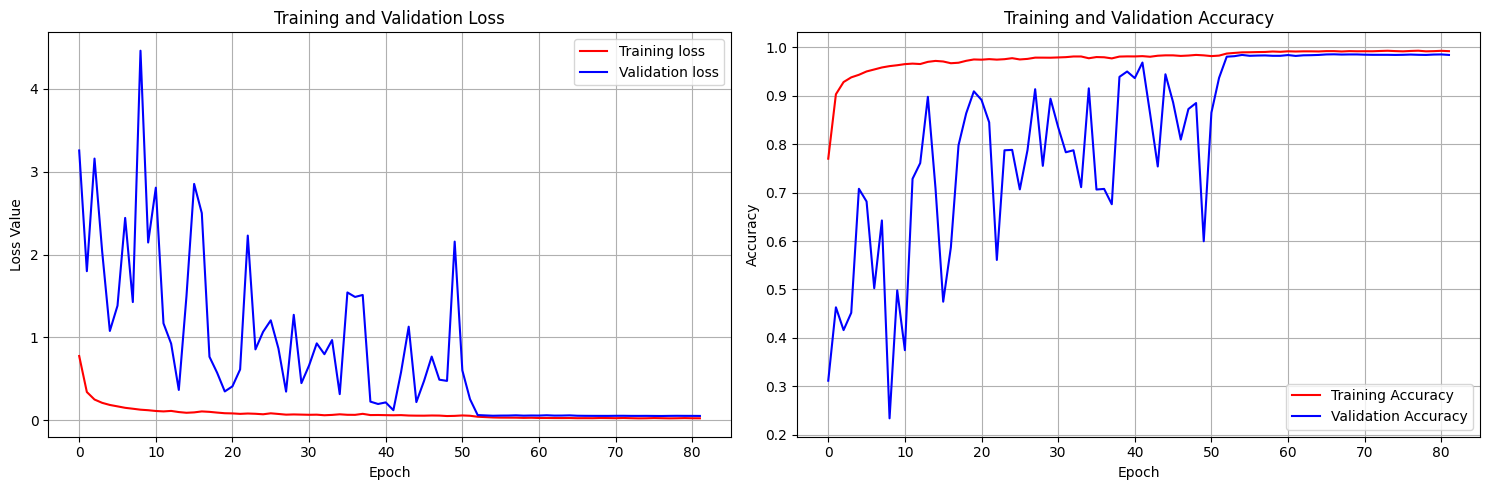

In [17]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

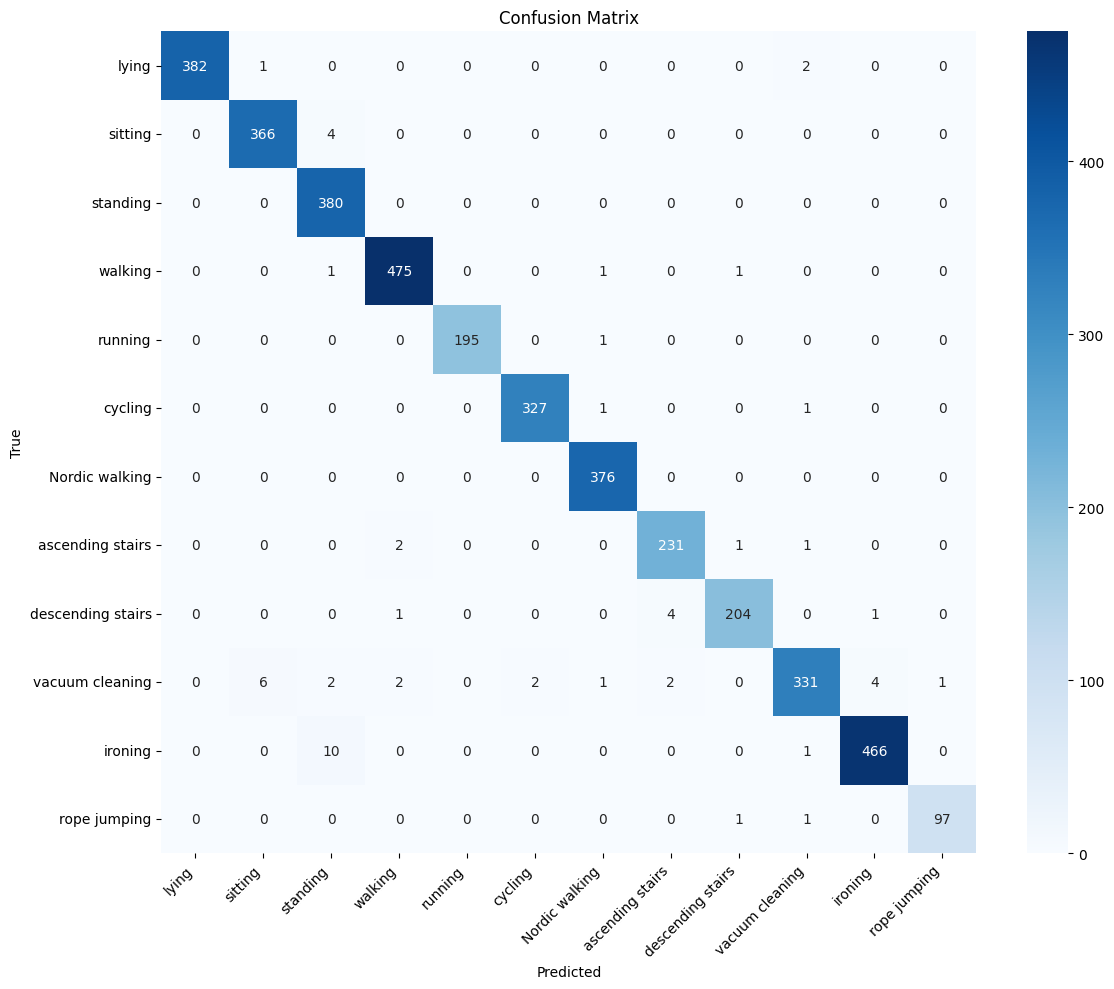

In [18]:
LABELS = ['lying', 'sitting', 'standing', 'walking', 'running', 'cycling', 'Nordic walking', 'ascending stairs', 'descending stairs', 'vacuum cleaning', 'ironing', 'rope jumping']

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')


if num_classes <= len(LABELS):
    plt.gca().set_xticklabels(LABELS[:num_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(LABELS[:num_classes], rotation=0)

plt.tight_layout()
plt.show()